In [1]:
from google.colab import drive, output

# drive.mount('/content/drive')
 
%cd "/content"
!rm -rf traffic_sign_detection
!git clone https://github.com/ptran1203/traffic_sign_detection
#!wget https://www.kaggle.com/phhasian0710/za-traffic-2020/download/archive.zip
#!unzip /content/archive.zip
%cd traffic_sign_detection
output.clear()

In [10]:
!pip install gdown
import gdown
url = "https://www.kaggle.com/phhasian0710/za-traffic-2020/download"
output = "archive.zip"
gdown.download(url, output, quiet=False)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Downloading...
From: https://www.kaggle.com/phhasian0710/za-traffic-2020/download
To: /content/archive.zip
5.28kB [00:00, 3.07MB/s]


'archive.zip'

### Download data and train model

In [3]:
%cd "/content/traffic_sign_detection"
!./download_data.sh
# !python3 train.py --input /content/dataset/za_traffic_2020/traffic_train/images\
#                   --backbone resnet50\
#                   --batch-size 4\
#                   --checkpoint-dir /content/weights\
#                   --init-from weights/weight_resnet50.h5\

串流輸出內容已截斷至最後 5000 行。
  inflating: /content/dataset/za_traffic_2020/traffic_public_test/images/11513.png  
  inflating: /content/dataset/za_traffic_2020/traffic_public_test/images/11598.png  
  inflating: /content/dataset/za_traffic_2020/traffic_public_test/images/116.png  
  inflating: /content/dataset/za_traffic_2020/traffic_public_test/images/11617.png  
  inflating: /content/dataset/za_traffic_2020/traffic_public_test/images/1165.png  
  inflating: /content/dataset/za_traffic_2020/traffic_public_test/images/11653.png  
  inflating: /content/dataset/za_traffic_2020/traffic_public_test/images/11683.png  
  inflating: /content/dataset/za_traffic_2020/traffic_public_test/images/11684.png  
  inflating: /content/dataset/za_traffic_2020/traffic_public_test/images/1169.png  
  inflating: /content/dataset/za_traffic_2020/traffic_public_test/images/11742.png  
  inflating: /content/dataset/za_traffic_2020/traffic_public_test/images/11752.png  
  inflating: /content/dataset/za_traffic_2020/tr

### Run prediction

In [4]:
!python3 prediction.py --input /content/dataset/za_traffic_2020/traffic_public_test/images\
            --output /content/submission.json\
            --weight /content/traffic_sign_detection/weights/weight_densenet121.h5\
            --scales 1024\
            --tiling
                    #    --weight /content/weights/weight_densenet121.h5\

2023-06-14 01:19:57.700852: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-14 01:19:59.655076: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-06-14 01:20:04.765225: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-14 01:20:05.380719: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA n

In [5]:
from prediction import get_inference_model, Prediction
import cv2
import utils
import importlib
import os

weight = 'weights/weight_densenet121.h5'
backbone = weight.split("_")[-1].replace(".h5", "")

predictor = Prediction(get_inference_model(weight, backbone))

/usr/local/lib/python3.10/dist-packages/keras/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


#### 增加以下程式碼至 utils.py
```
def visualize_detections_with_label(
    image, boxes, classes, scores, label, figsize=(15, 15), linewidth=2, color=[1, 0, 0],
    box_true=None, label_true=None, save_path=''
):
    """Visualize Detections"""
    image = np.array(image, dtype=np.uint8)
    plt.figure(figsize=figsize)

    plt.axis("off")
    plt.imshow(image)
    ax = plt.gca()
    for i in range(len(boxes)):
        box, _cls, score = boxes[i], classes[i], scores[i]
        _cls = label[int(_cls)]
        text = "{}: {:.2f}".format(_cls, score)
        x1, y1, x2, y2 = box
        w, h = x2 - x1, y2 - y1
        patch = plt.Rectangle(
            [x1, y1], w, h, fill=False, edgecolor=color, linewidth=linewidth
        )
        ax.add_patch(patch)
        ax.text(
            x1,
            y1,
            text,
            bbox={"facecolor": color, "alpha": 0.4},
            clip_box=ax.clipbox,
            clip_on=True,
        )

    if box_true is not None and label_true is not None:
        for i in range(len(box_true)):
            box_t, cls_t = box_true[i], label_true[i]
            text = "{}: {:.2f}".format(cls_t, 1.0)
            x1, y1, w, h = box_t
            patch = plt.Rectangle(
                [x1, y1], w, h, fill=False,
                edgecolor=[1,1,1], linewidth=3
            )
            ax.add_patch(patch)
    
    if save_path:
        plt.savefig(save_path, bbox_inches='tight')
    else:
        plt.show()

    return ax
```

In [6]:
importlib.reload(utils)

<module 'utils' from '/content/traffic_sign_detection/utils.py'>

In [7]:
LABEL_MAP = {
    1: "No entry",
    2: "No parking / waiting",
    3: "No turning",
    4: "Max Speed",
    5: "Other prohibition signs",
    6: "Warning",
    7: "Mandatory",
}

1/1 [==============================] - 6s 6s/step
tf.Tensor([5. 6.], shape=(2,), dtype=float32)
tf.Tensor([0.9496116 0.9436156], shape=(2,), dtype=float32)


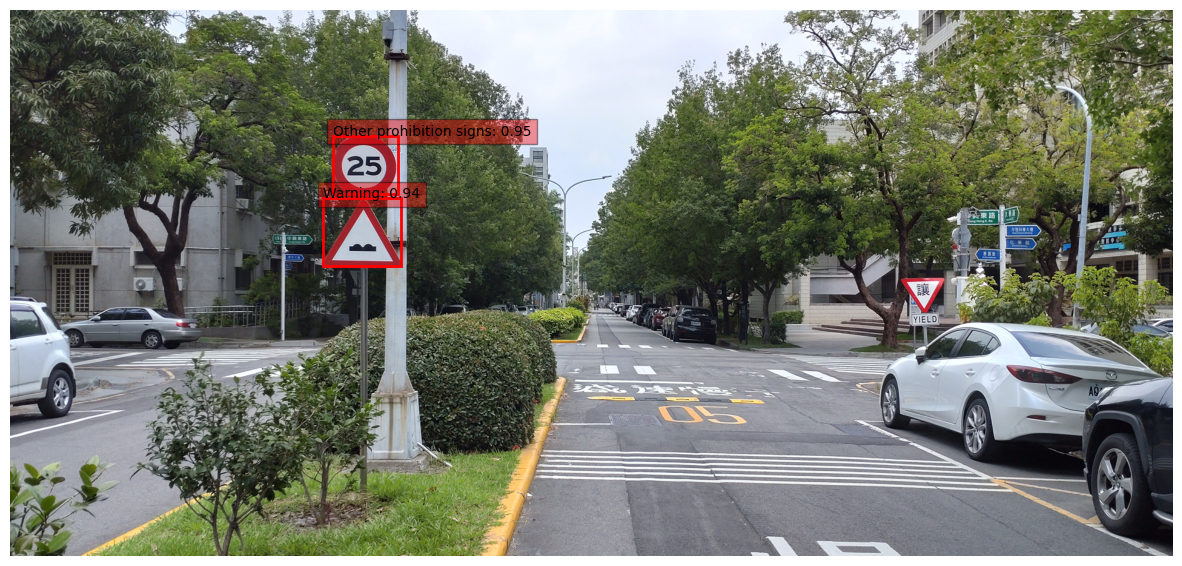

<Axes: >

In [8]:
file_path = 'images/DEMO_001.png'
image, boxes, scores, classes = predictor.detect_single_image(
        cv2.imread(file_path)[..., ::-1], tiling=True)

print(classes)
print(scores)
utils.visualize_detections_with_label(image, boxes, classes, scores, LABEL_MAP)

1/1 [==============================] - 0s 84ms/step
tf.Tensor([6. 6. 1. 6. 3. 5. 5. 4. 5.], shape=(9,), dtype=float32)
tf.Tensor(
[0.9389094  0.9063344  0.87885845 0.8694005  0.8171977  0.7954783
 0.6308088  0.5972172  0.5374993 ], shape=(9,), dtype=float32)


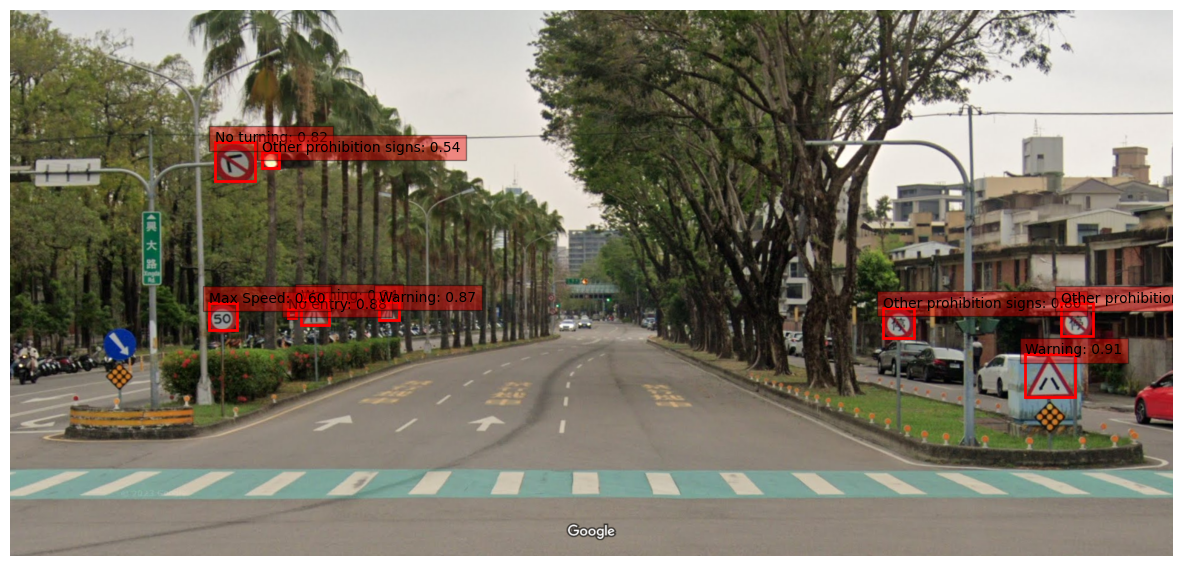

<Axes: >

In [9]:
file_path = 'images/DEMO_002.png'
image, boxes, scores, classes = predictor.detect_single_image(
        cv2.imread(file_path)[..., ::-1], tiling=True)

print(classes)
print(scores)
utils.visualize_detections_with_label(image, boxes, classes, scores, LABEL_MAP)

In [10]:
file_path = 'images/DEMO_003.png'
image, boxes, scores, classes = predictor.detect_single_image(
        cv2.imread(file_path)[..., ::-1], tiling=True)

print(classes)
print(scores)
utils.visualize_detections_with_label(image, boxes, classes, scores, LABEL_MAP)

1/1 [==============================] - 0s 84ms/step
tf.Tensor([3. 3.], shape=(2,), dtype=float32)
tf.Tensor([0.8650619 0.8555936], shape=(2,), dtype=float32)


<Axes: >

In [11]:
file_path = 'images/DEMO_004.png'
image, boxes, scores, classes = predictor.detect_single_image(
        cv2.imread(file_path)[..., ::-1], tiling=True)

print(classes)
print(scores)
utils.visualize_detections_with_label(image, boxes, classes, scores, LABEL_MAP)

1/1 [==============================] - 0s 82ms/step
tf.Tensor([3. 3. 1.], shape=(3,), dtype=float32)
tf.Tensor([0.89955455 0.8803259  0.5728615 ], shape=(3,), dtype=float32)


<Axes: >

In [12]:
file_path = 'images/DEMO_005.png'
image, boxes, scores, classes = predictor.detect_single_image(
        cv2.imread(file_path)[..., ::-1], tiling=True)

print(classes)
print(scores)
utils.visualize_detections_with_label(image, boxes, classes, scores, LABEL_MAP)

1/1 [==============================] - 0s 99ms/step
tf.Tensor([1. 3. 3. 3. 3. 3. 5. 3. 5. 5.], shape=(10,), dtype=float32)
tf.Tensor(
[0.96933115 0.9166374  0.85634804 0.7697703  0.75180125 0.7400456
 0.68111396 0.61107385 0.5466215  0.52200097], shape=(10,), dtype=float32)


<Axes: >

1/1 [==============================] - 0s 81ms/step
tf.Tensor([3. 4. 5.], shape=(3,), dtype=float32)
tf.Tensor([0.7445865  0.72485226 0.5021628 ], shape=(3,), dtype=float32)


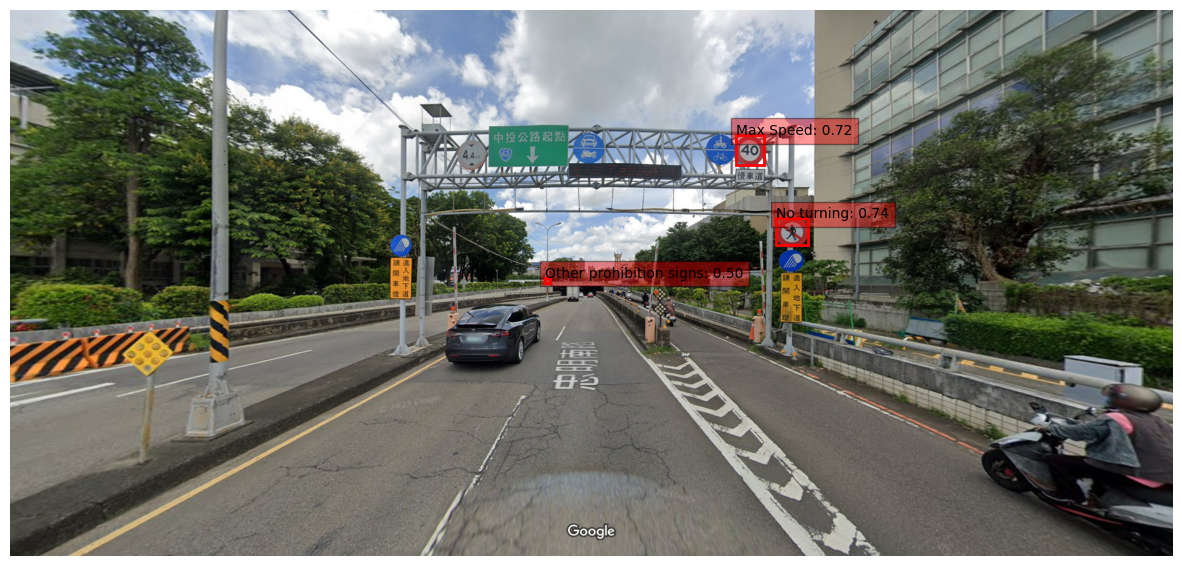

<Axes: >

In [13]:
file_path = 'images/DEMO_006.png'
image, boxes, scores, classes = predictor.detect_single_image(
        cv2.imread(file_path)[..., ::-1], tiling=True)

print(classes)
print(scores)
utils.visualize_detections_with_label(image, boxes, classes, scores, LABEL_MAP)